# Marked Hawkes Process

This file is the followin of the previous notebook on Hawkes processes, it focuses on Marked hawkes processes to descirbe the behavior of three trading data :

- shibainu usdt
- dogecoin usdt
- pengu usdt

all of the data are made of 10000 trades taken the 10$^{10}$ october 2025. Our goal here is to build two types of hawkes processes, the first one simply consists of a Hawkes process marked by the volume (in sales and purchases), with a bigger effect of the bigger volumes on the market. The second one will also consider the log-return and the volatility.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Definition
With the same quantities as before, we call **marked Hawkes processes** the stochastic processes which are the same as Hawkes processes except that their intensity is given by:
$$
\lambda_t^* = \lambda + \sum_{T_i < t} \mu(t - T_i, m_i^1, m_i^2, \dots, m_i^n),
$$
where:
- $\lambda > 0$ is the **background arrival rate**,
- $\mu: \mathbb{R}_+ \to \mathbb{R}_+$ is the **excitation function**,
- $(T_i)$ are the past event times of the process,
- $(m_i^1, m_i^2, \dots, m_i^n)$ are the marks associated with the event time $T_i$, respectively valued in different spaces (e.g., $\mathbb{R}$, $\mathbb{R}_+^*$, $\mathbb{N}$, $\{1,2,\dots,N\}$, ...).


We do not address here the question of whether the marks are or are not independent of the other marks and of the event times. In our first example, we will make this assumption, using the volume as a multiplicative factor of the excitation function: this model is also known as the **linear marked Hawkes process**.


### Symmetric Marked Hawkes Process

**Basic Assumptions**

In their paper, Kyungsub Lee and Byoung Ki Seo make the following assumptions:
- We can describe the processes of buy and sell independently as $N_1$ and $N_2$.
- The marks are valued in $\mathbb{N}$, and the jumps of prices change by a minimal rate $\delta$ depending on the currency/the stock.
- $N_{gi}(\cdot) := N_i( \cdot,\mathbb{N})$ are point processes.
- The intensity of the Hawkes process takes the following form:
$$
\lambda _{gi} = \mu + \sum _{j =1,2} q_{ij} \sum _{-\infty < u_l <t}g_{ij}(k_j(u_l))\phi _{ij}(t-u_l)
$$
with:
 - $\mu$: the intensity of the underlying Poisson process,
 - $u_l$: an event time,
 - $k_j(u_l)$: the mark size associated with the event time $u_l$, previously described as $m_l^j$,
 - $g_{ij}(\cdot)$: a function that emphasizes the influence on the intensity by the excitation function,
 - $\phi(t - u_l)$: a function that represents the decaying influence of the mark associated with $u_l$ over time. It is denoted as the kernel or excitation function. It decays exponentially:
$$
\phi _{ij} (t-u) = \phi (t-u) = \beta e ^{-\beta (t-u)}, \quad \beta > 0.


**Normalisation**
- The kernel needs to be normalised such that:
    $$\int _0 ^{\infty}  \phi(t) \, dt = 1$$
- The impact of the marks $g_{ij}(k)$ must be normalised:
    $$\mathbb{E}(g_{ij}(k)) = 1$$


**Branching Matrix**
We define the branching matrix $\mathcal{Q}$ as:
$$
\mathcal{Q} = (q_{ij})_{i,j = 1,2}
$$
From a Markovian point of view, this represents the dependencies between the different marks. In our first study case, we will consider that they are independent, which results in a diagonal branching matrix.


If we simplify the assumptions made by Kyungsub Lee and Byoung Ki Seo we have : 

 - $\lambda_{gi}$ are stationary
 - $g(k) = \frac{k}{E}$ where $E = \mathbb{E}(k)$ is the normalisation constant
 - $q_{11} = q_{22} = \frac{\alpha}{\beta}E$
 - We also assume that :
    $$ \mathbb{E}( k_i \lambda _{gi} (t) ) = K_{i \lambda_{gi}} \mathbb{E}(\lambda _{gi} (t) )$$
  such that : $$\frac{\alpha}{\beta}K_{i \lambda_{gi}}  < 1$$


In the following you will see how

In [2]:
def convert_emit_time_to_float(df):
    # Convert 'emit_time' to pandas datetime
    df['emit_time_dt'] = pd.to_datetime(df['emit_time'])
    # Convert to unix timestamp as float
    df['emit_time_float'] = df['emit_time_dt'].astype(np.int64) / 1e9
    return df
    
shib_df = pd.read_csv('data/shib_10k.csv')
pengu_df = pd.read_csv('data/pengu_10k.csv')
doge_df = pd.read_csv('data/doge_10k.csv')

shib_df = convert_emit_time_to_float(shib_df)
pengu_df = convert_emit_time_to_float(pengu_df)
doge_df = convert_emit_time_to_float(doge_df)

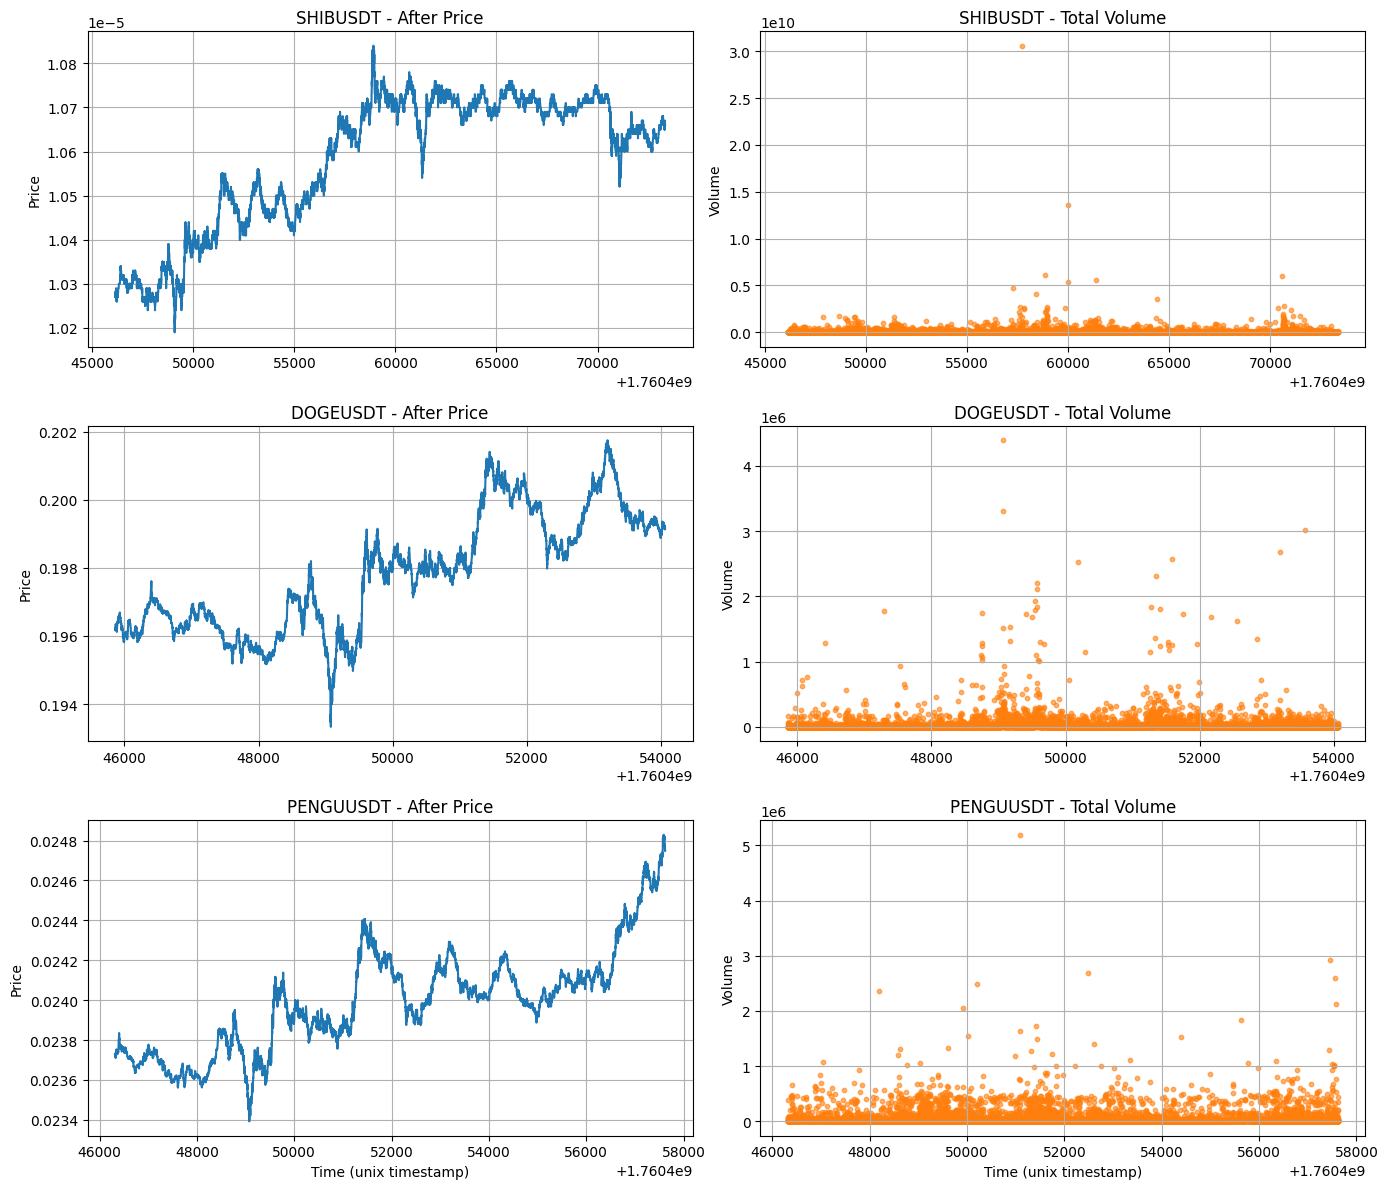

In [4]:

fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharex=False)

cryptos = [
    ('SHIBUSDT', shib_df, 0),
    ('DOGEUSDT', doge_df, 1),
    ('PENGUUSDT', pengu_df, 2)
]

for name, df, idx in cryptos:
    # Price plot (left column)
    axs[idx, 0].plot(df['emit_time_float'], df['after_price'], color='tab:blue')
    axs[idx, 0].set_title(f'{name} - After Price')
    axs[idx, 0].set_ylabel('Price')
    axs[idx, 0].grid(True)

    # Volume scatter plot (right column)
    axs[idx, 1].scatter(df['emit_time_float'], df['total_volume'], s=10, color='tab:orange', alpha=0.6)
    axs[idx, 1].set_title(f'{name} - Total Volume')
    axs[idx, 1].set_ylabel('Volume')
    axs[idx, 1].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel('Time (unix timestamp)')

plt.tight_layout()
plt.show()

In [6]:
def temporal_train_test_split(df, train_ratio=0.8):
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    test_df = df.iloc[split_idx:].reset_index(drop=True)
    return train_df, test_df

def split_buy_sell(df):
    # Split based on which is larger: buy_volume or sell_volume
    buy_trades = df[df['buy_volume'] > df['sell_volume']].reset_index(drop=True)
    sell_trades = df[df['sell_volume'] > df['buy_volume']].reset_index(drop=True)
    return buy_trades, sell_trades

shib_buy, shib_sell = split_buy_sell(shib_df)
doge_buy, doge_sell = split_buy_sell(doge_df)
pengu_buy, pengu_sell = split_buy_sell(pengu_df)

shib_buy_train, shib_buy_test = temporal_train_test_split(shib_buy)
shib_sell_train, shib_sell_test = temporal_train_test_split(shib_sell)
doge_buy_train, doge_buy_test = temporal_train_test_split(doge_buy)
doge_sell_train, doge_sell_test = temporal_train_test_split(doge_sell)
pengu_buy_train, pengu_buy_test = temporal_train_test_split(pengu_buy)
pengu_sell_train, pengu_sell_test = temporal_train_test_split(pengu_sell)


Then we build the estimation function 

In [7]:
def estimation_function_hawkes_marked(temporal_trainset,values_train_set,seil = 0.3) :
    expected_K = np.mean(values_train_set)
    expected_Lambda = len(temporal_trainset)/(temporal_trainset[-1] - temporal_trainset[0])
    increments = np.diff(temporal_trainset)
    beta = 1/(20*np.sqrt(np.mean(increments**2)))
    mu = seil * expected_Lambda
    alpha = (beta/expected_K) * (expected_Lambda-mu)

    return mu,alpha,beta

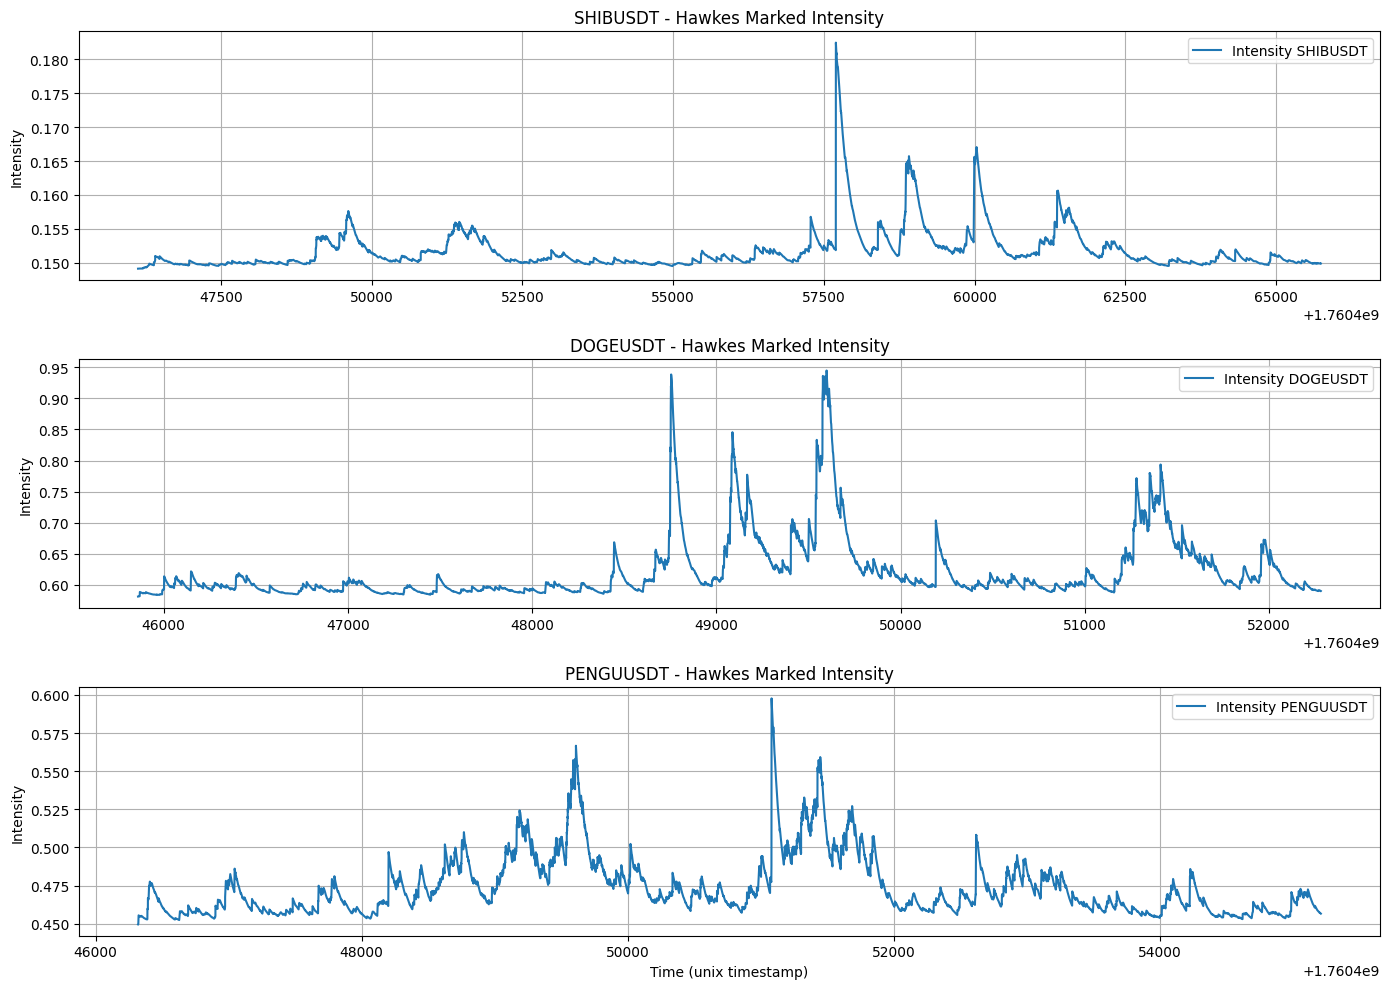

In [8]:
def reconstruct_intensity(train_df, mark_col='total_volume', time_col='emit_time_float', seil=0.9):
    # Extract event times and marks
    event_times = train_df[time_col].values
    marks = train_df[mark_col].values

    # Estimate parameters
    
    mu, alpha, beta = estimation_function_hawkes_marked(event_times, marks, seil=seil)
    Lambda = np.count_nonzero(event_times) / (event_times[-1] - event_times[0])
    K = np.mean(marks)
    alpha = alpha 
    c = -1000*np.log(beta / Lambda) * (1 / beta)
    # Reconstruct intensity
    intensities = np.zeros_like(event_times)
    for i, t in enumerate(event_times):
        # Find events in [t-c, t)
        mask = (event_times < t) & (event_times >= t - c)
        u_times = event_times[mask]
        k_marks = marks[mask]
        if len(u_times) > 0:
            excitation = np.sum(alpha * k_marks * np.exp(-beta * (t - u_times)))
        else:
            excitation = 0
        intensities[i] = mu + excitation
    return event_times, intensities, (mu, alpha, beta, c)

# Estimation and intensity reconstruction for each train set
results = {}
for name, df, idx in cryptos:
    train_df = None
    if name == 'SHIBUSDT':
        train_df = shib_buy_train
    elif name == 'DOGEUSDT':
        train_df = doge_buy_train
    elif name == 'PENGUUSDT':
        train_df = pengu_buy_train
    event_times, intensities, params = reconstruct_intensity(train_df)
    results[name] = {
        'event_times': event_times,
        'intensities': intensities,
        'params': params
    }

# Example plot for each crypto
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
for i, name in enumerate(results):
    axs[i].plot(results[name]['event_times'], results[name]['intensities'], label=f'Intensity {name}')
    axs[i].set_title(f'{name} - Hawkes Marked Intensity')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel('Time (unix timestamp)')
plt.tight_layout()
plt.show()

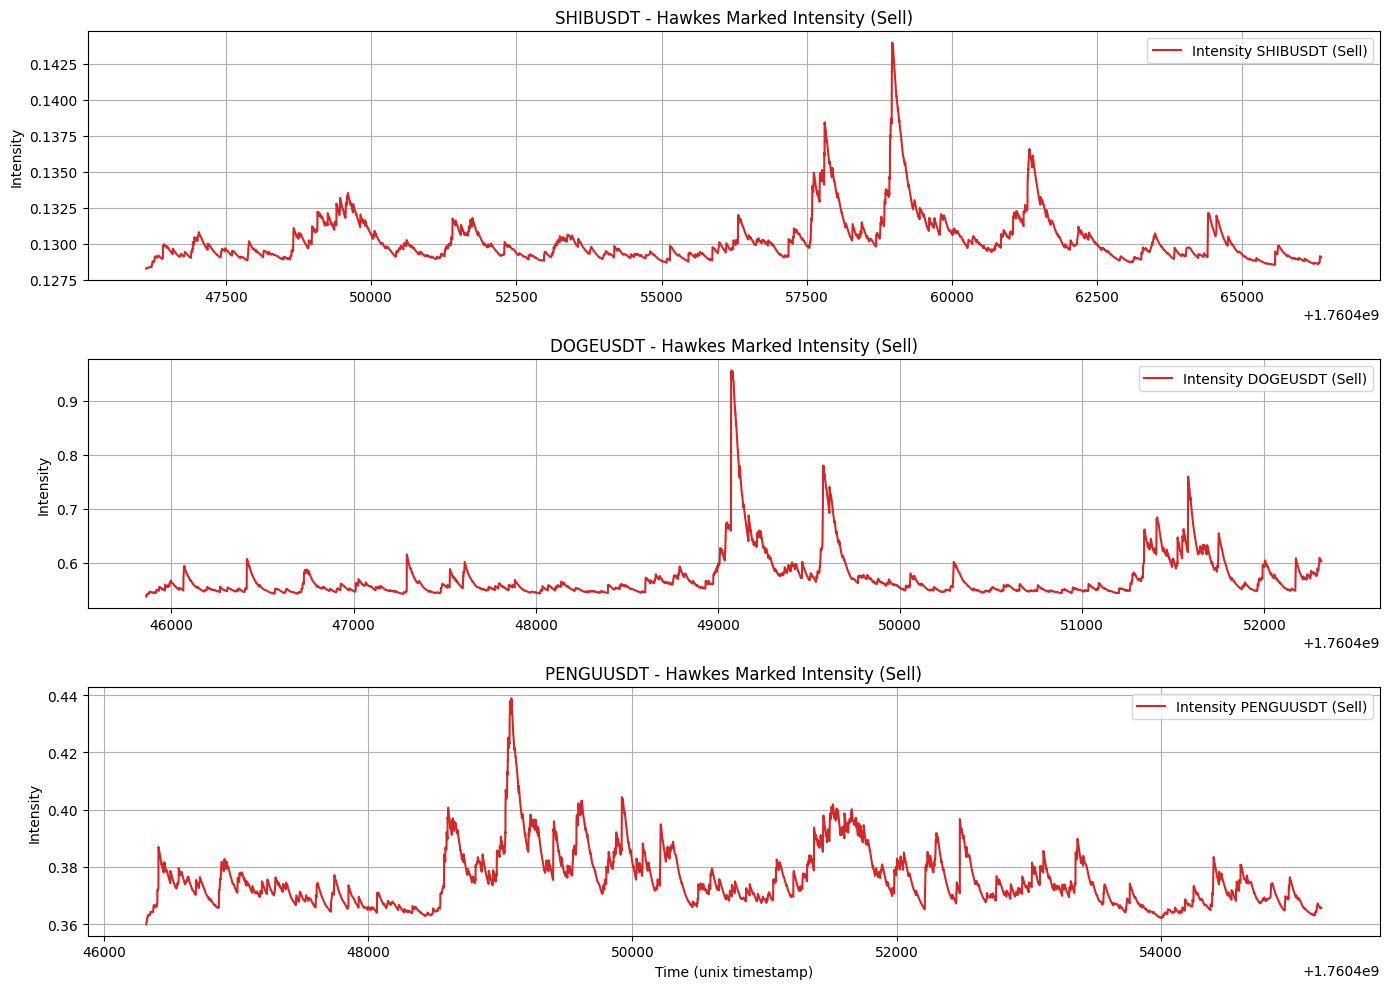

In [9]:
# Estimation and intensity reconstruction for each train set (SELL side)
results_sell = {}
for name, df, idx in cryptos:
    train_df = None
    if name == 'SHIBUSDT':
        train_df = shib_sell_train
    elif name == 'DOGEUSDT':
        train_df = doge_sell_train
    elif name == 'PENGUUSDT':
        train_df = pengu_sell_train
    event_times, intensities, params = reconstruct_intensity(train_df)
    results_sell[name] = {
        'event_times': event_times,
        'intensities': intensities,
        'params': params
    }

# Example plot for each crypto (SELL side)
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
for i, name in enumerate(results_sell):
    axs[i].plot(results_sell[name]['event_times'], results_sell[name]['intensities'], label=f'Intensity {name} (Sell)', color='tab:red')
    axs[i].set_title(f'{name} - Hawkes Marked Intensity (Sell)')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel('Time (unix timestamp)')
plt.tight_layout()
plt.show()

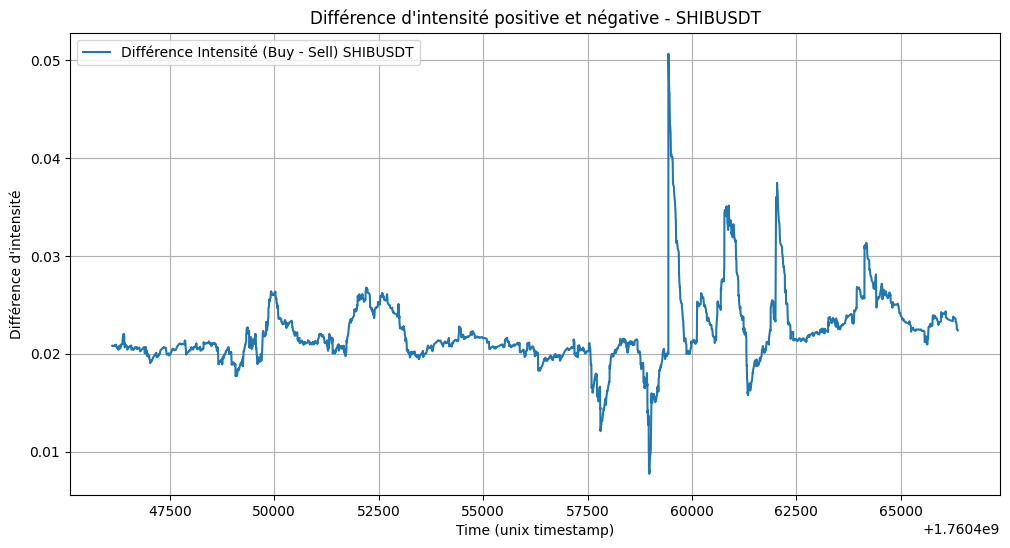

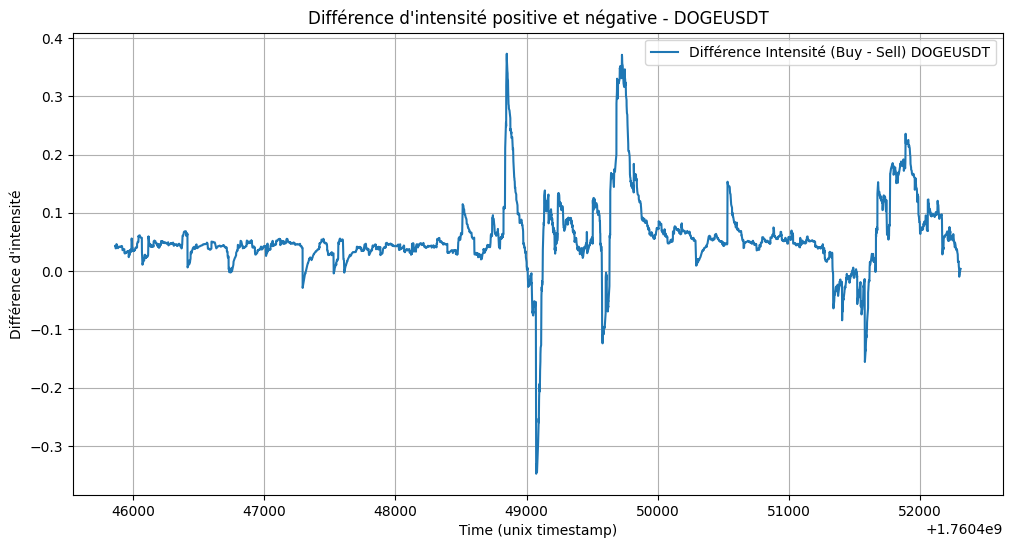

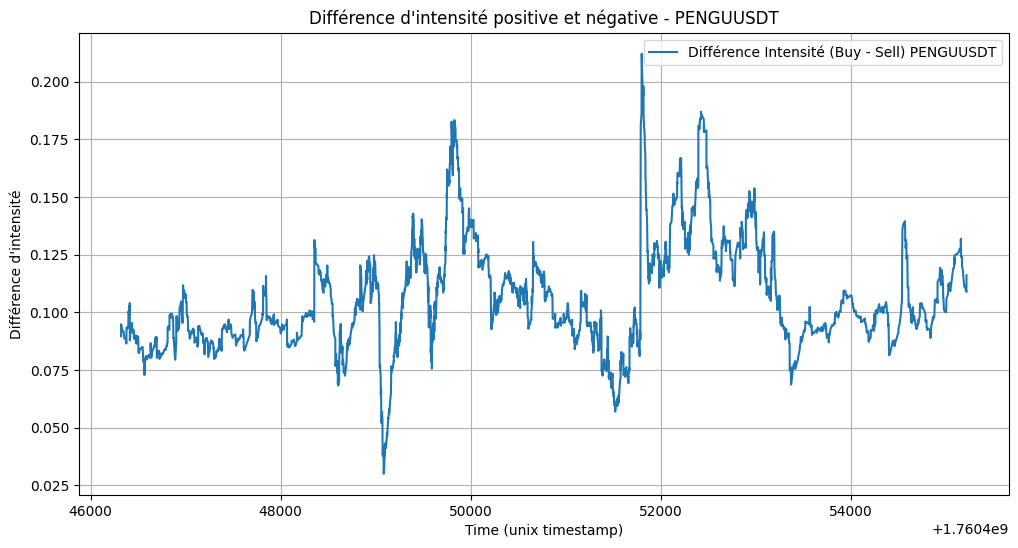

In [10]:
for name in results.keys():
    # Prendre la longueur minimale pour éviter les problèmes d'alignement
    min_len = min(len(results[name]['intensities']), len(results_sell[name]['intensities']))
    intensity_diff = results[name]['intensities'][:min_len] - results_sell[name]['intensities'][:min_len]
    event_times = results_sell[name]['event_times'][:min_len]

    plt.figure(figsize=(12, 6))
    plt.plot(event_times, intensity_diff, label=f"Différence Intensité (Buy - Sell) {name}")
    plt.title(f"Différence d'intensité positive et négative - {name}")
    plt.xlabel("Time (unix timestamp)")
    plt.ylabel("Différence d'intensité")
    plt.grid(True)
    plt.legend()
    plt.show()

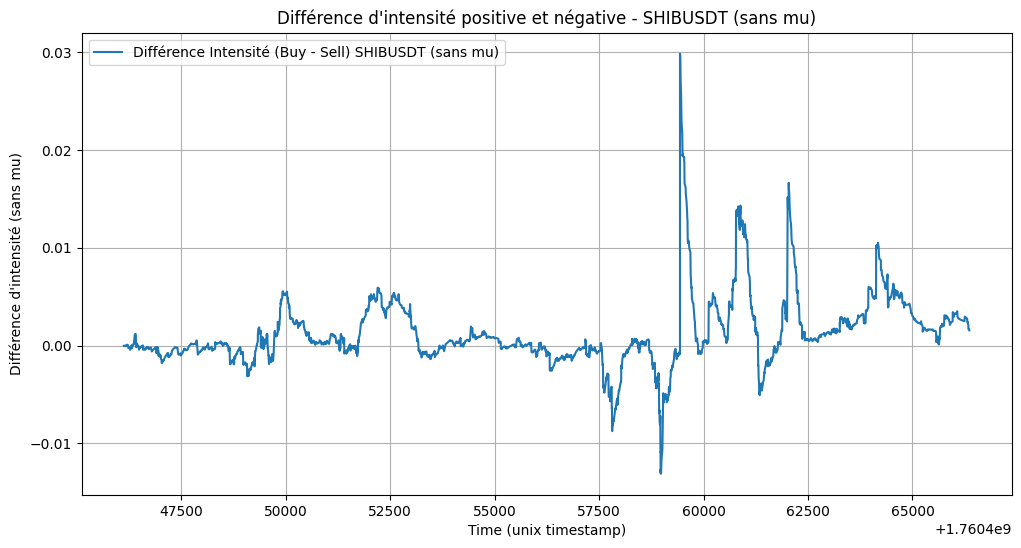

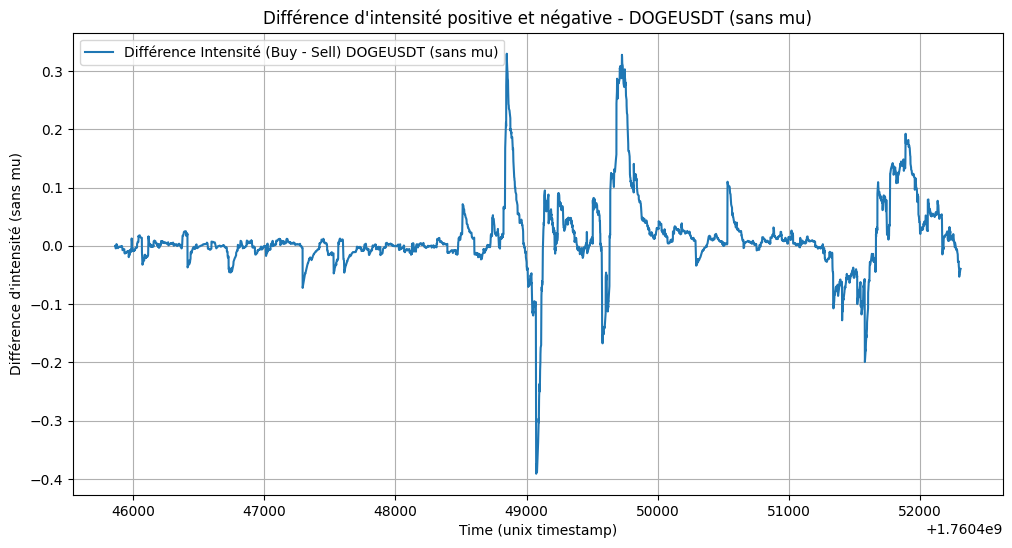

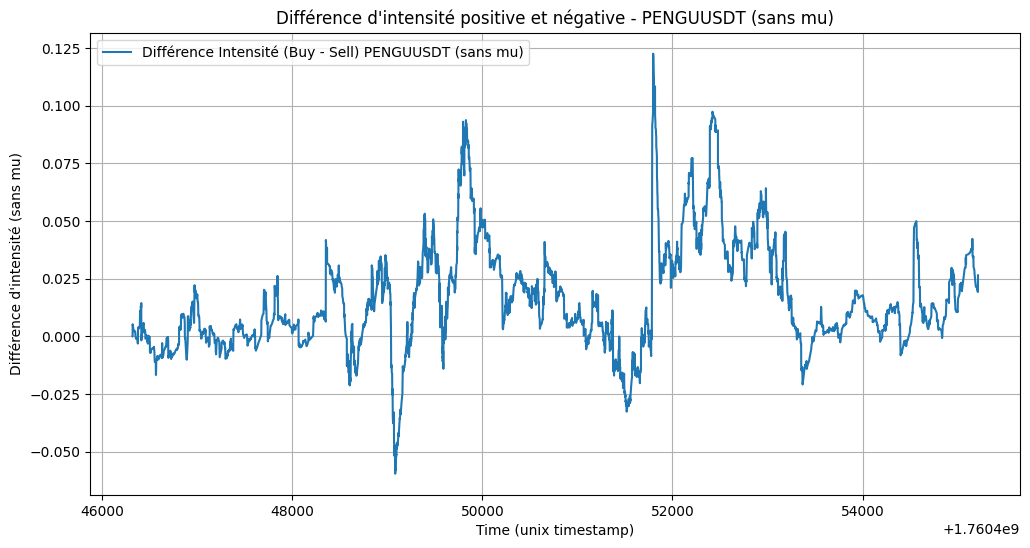

In [11]:
for name in results.keys():
    min_len = min(len(results[name]['intensities']), len(results_sell[name]['intensities']))
    # Remove mu from each intensity
    mu_buy = results[name]['params'][0]
    mu_sell = results_sell[name]['params'][0]
    intensity_diff = (results[name]['intensities'][:min_len] - mu_buy) - (results_sell[name]['intensities'][:min_len] - mu_sell)
    event_times = results_sell[name]['event_times'][:min_len]

    plt.figure(figsize=(12, 6))
    plt.plot(event_times, intensity_diff, label=f"Différence Intensité (Buy - Sell) {name} (sans mu)")
    plt.title(f"Différence d'intensité positive et négative - {name} (sans mu)")
    plt.xlabel("Time (unix timestamp)")
    plt.ylabel("Différence d'intensité (sans mu)")
    plt.grid(True)
    plt.legend()
    plt.show()

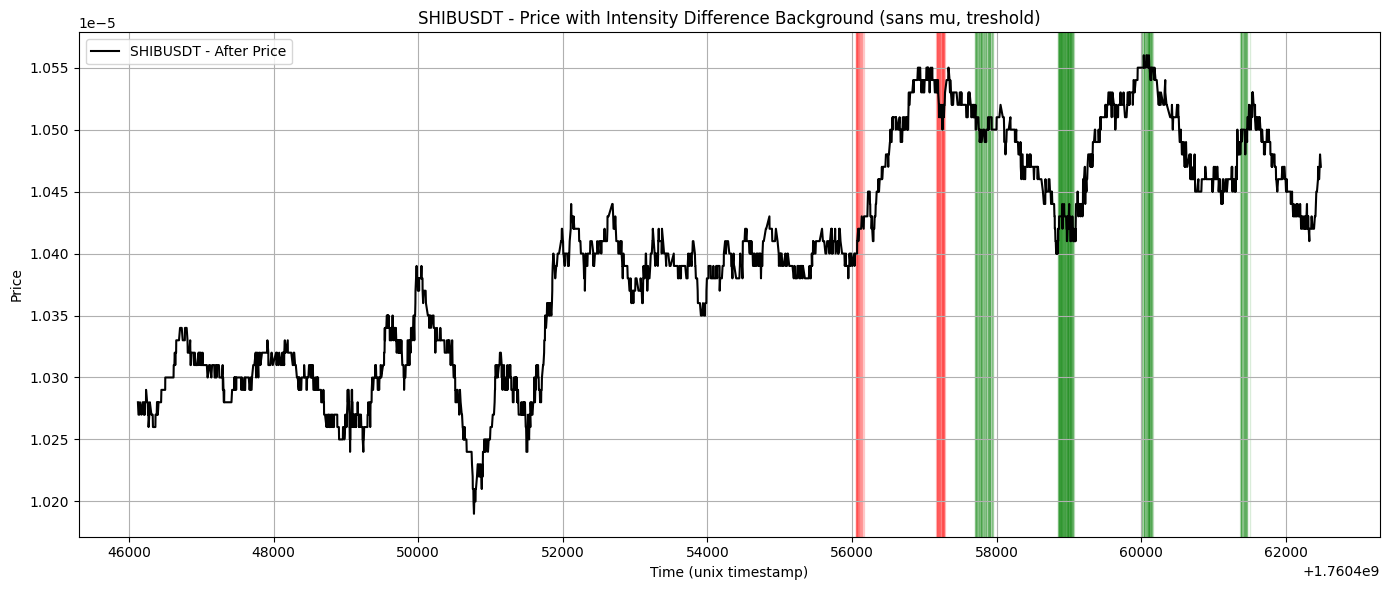

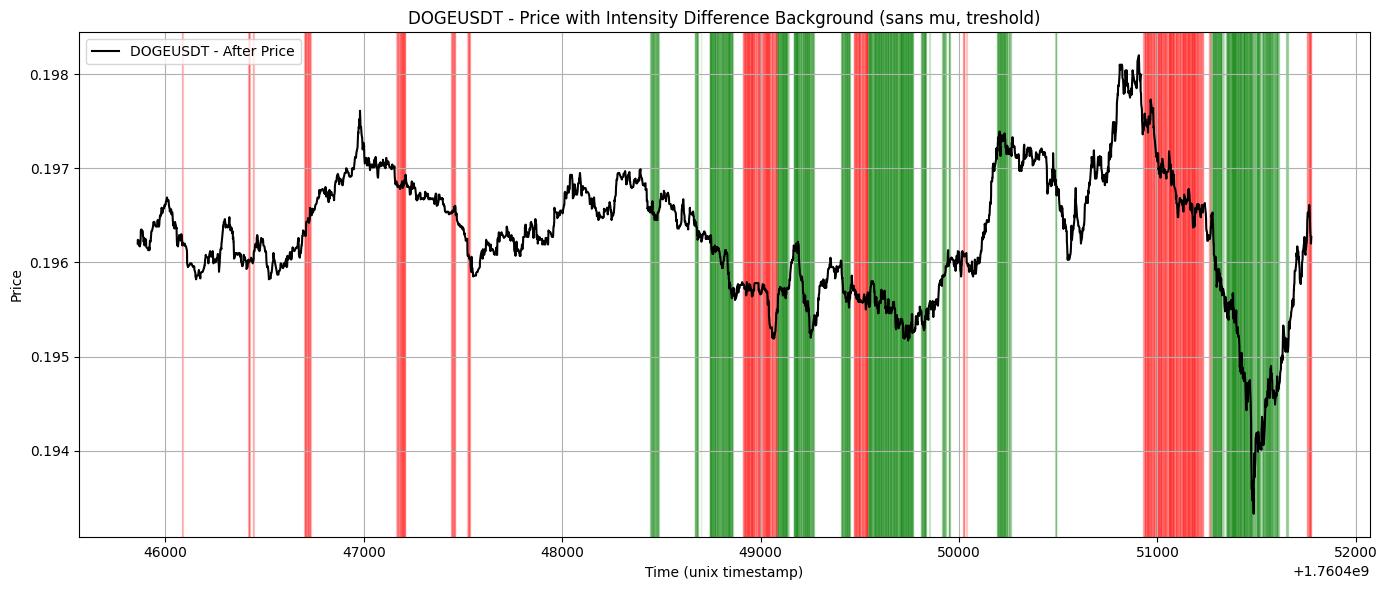

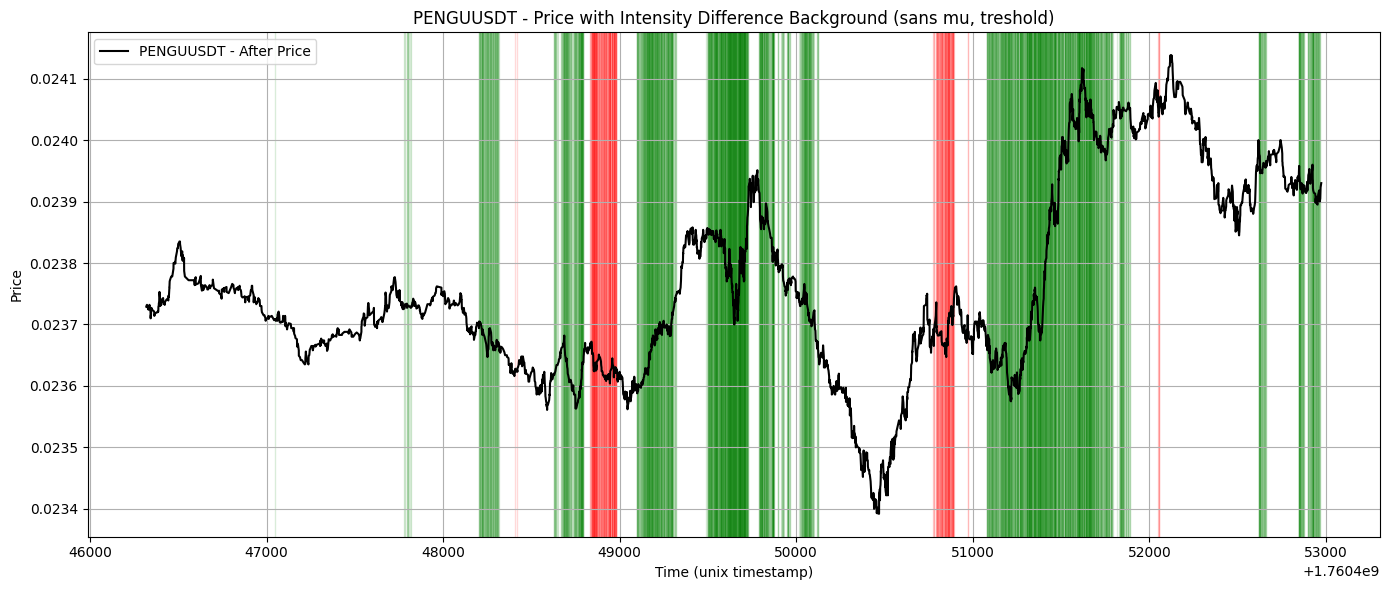

In [12]:
# Représentation des cours avec fond coloré selon la différence normalisée des intensités (Buy - Sell) sans mu
for name, df, idx in cryptos:
    min_len = min(len(results[name]['event_times']), len(results_sell[name]['event_times']))
    event_times = results[name]['event_times'][:min_len]
    price = df['after_price'].values[:min_len]
    # Remove mu from each intensity
    mu_buy = results[name]['params'][0]
    mu_sell = results_sell[name]['params'][0]
    intensity_buy = results[name]['intensities'][:min_len] - mu_buy
    intensity_sell = results_sell[name]['intensities'][:min_len] - mu_sell
    diff_norm = (intensity_buy - intensity_sell) / (np.abs(intensity_buy) + np.abs(intensity_sell) + 1e-9)

    # Ajout du treshold
    threshold = 0.05 * np.mean([mu_buy, mu_sell])

    plt.figure(figsize=(14, 6))
    plt.plot(event_times, price, label=f'{name} - After Price', color='black', linewidth=1.5)

    # Ajout du fond coloré avec treshold
    for i in range(min_len - 1):
        if np.abs(intensity_buy[i] - intensity_sell[i]) > threshold:
            color = 'green' if diff_norm[i] > 0 else 'red'
            plt.axvspan(event_times[i], event_times[i+1], color=color, alpha=0.15)

    plt.title(f'{name} - Price with Intensity Difference Background (sans mu, treshold)')
    plt.xlabel('Time (unix timestamp)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## trading strategy

Our spot trading strategy starts with an initial capital of 1,000 USDT, and at each predefined trading event, we evaluate the market intensity. If the intensity surpasses a set threshold, we allocate the entire available capital to either buy or sell based on the current trend: buying if the trend is positive, or selling if it is negative. When we buy, our wealth fluctuates with the asset’s price movement, while selling locks in the capital in USDT until the next trading opportunity. This approach ensures that we only act on strong signals, fully committing our resources to capitalize on identified trends.

We do not account for fees or spreads, as they complicate real-world implementation. Instead, we focus solely on identifying the potential advantage (or edge) this model may provide.



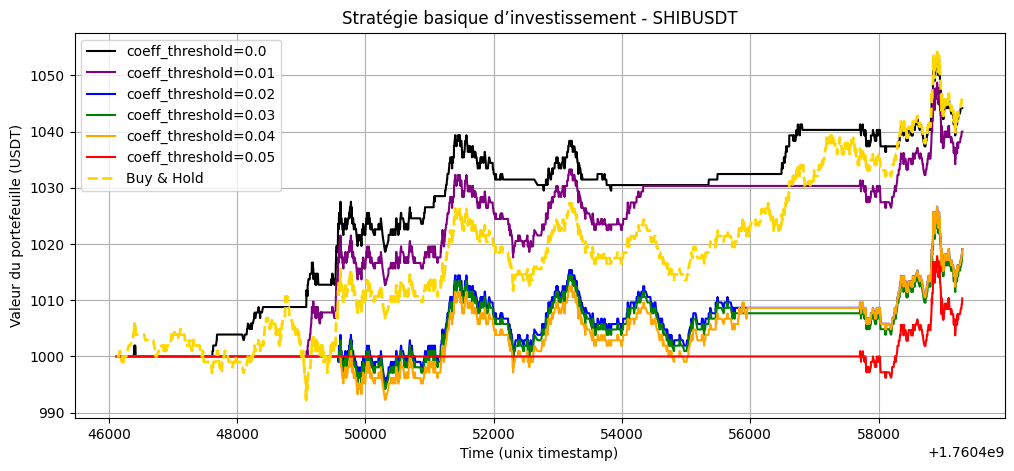

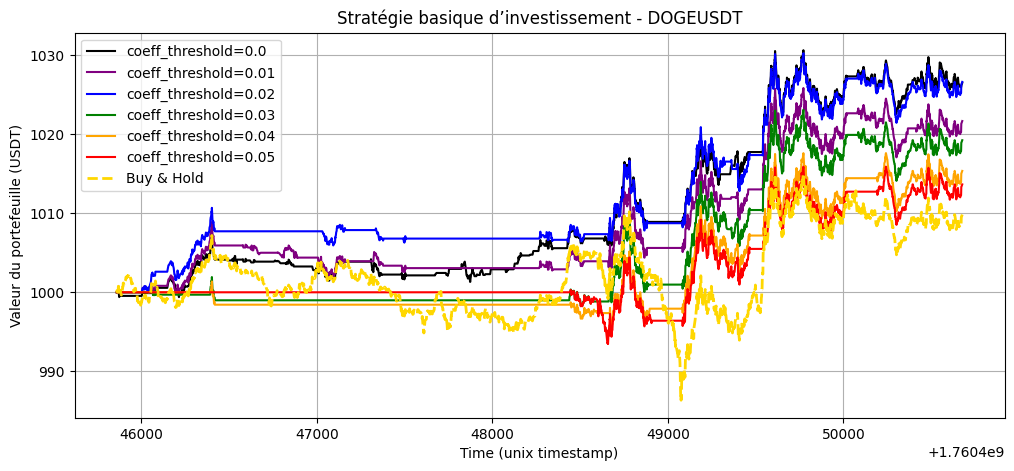

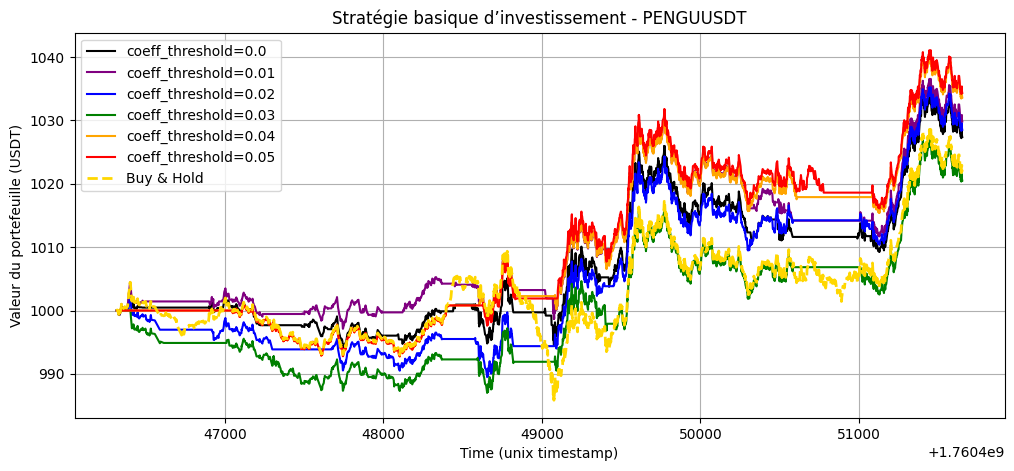

In [13]:
# --- Paramètres initiaux ---
initial_usdt = 1000.0

# --- Fonction pour exécuter la stratégie avec threshold ---
def run_strategy(pair_name, results_buy, results_sell, price_data, coeff_threshold=0.05):
    usdt = initial_usdt
    crypto = 0.0

    # Récupération des données
    event_times = np.asarray(results_buy[pair_name]['event_times'])
    intensity_buy = np.asarray(results_buy[pair_name]['intensities'])
    mu_buy = results_buy[pair_name]['params'][0]
    intensity_sell = np.asarray(results_sell[pair_name]['intensities'])
    mu_sell = results_sell[pair_name]['params'][0]
    price = np.asarray(price_data['after_price'].values)

    # --- Alignement / tronquage (80% des données communes) ---
    common_len = min(len(event_times), len(intensity_buy), len(intensity_sell), len(price))
    if common_len == 0:
        raise ValueError(f"Les données pour {pair_name} sont vides.")
    n_keep = max(1, int(0.8 * common_len))

    event_times = event_times[:n_keep]
    intensity_buy = intensity_buy[:n_keep]
    intensity_sell = intensity_sell[:n_keep]
    price = price[:n_keep]

    # --- Calcul de la différence d’intensité ---
    diff_intensity = (intensity_buy - mu_buy) - (intensity_sell - mu_sell)
    threshold = coeff_threshold * np.mean([mu_buy, mu_sell])

    # --- Simulation portefeuille ---
    portfolio_value = []
    for t in range(len(event_times)):
        current_price = price[t]
        value = usdt + crypto * current_price
        portfolio_value.append(value)

        # Décision d’investissement
        if diff_intensity[t] > threshold and usdt > 0:
            crypto = usdt / current_price
            usdt = 0.0
        elif diff_intensity[t] < -threshold and crypto > 0:
            usdt = crypto * current_price
            crypto = 0.0

    return event_times, portfolio_value, price

# --- Fonction pour calculer buy-and-hold ---
def buy_and_hold(price, initial_usdt):
    crypto = initial_usdt / price[0]  # acheter tout au début
    return crypto * price  # jamais vendu

# --- Liste des coefficients de seuil à tester ---
coeffs = [0.01*i for i in range(10)]
colors = ['black', 'purple', 'blue', 'green', 'orange', 'red']

# --- Fonction pour tracer les résultats pour une paire avec buy-and-hold ---
def plot_thresholds_with_bh(pair_name, results_buy, results_sell, price_data):
    plt.figure(figsize=(12, 5))
    for coeff, color in zip(coeffs, colors):
        event_times, portfolio, price = run_strategy(pair_name, results_buy, results_sell, price_data, coeff_threshold=coeff)
        plt.plot(event_times, portfolio, label=f"coeff_threshold={coeff}", color=color)
    
    # Buy-and-hold
    bh_portfolio = buy_and_hold(price, initial_usdt)
    plt.plot(event_times, bh_portfolio, label="Buy & Hold", color='gold', linewidth=2, linestyle='--')

    plt.xlabel('Time (unix timestamp)')
    plt.ylabel('Valeur du portefeuille (USDT)')
    plt.title(f"Stratégie basique d’investissement - {pair_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Graphiques séparés pour chaque paire ---
plot_thresholds_with_bh('SHIBUSDT', results, results_sell, shib_buy_train)
plot_thresholds_with_bh('DOGEUSDT', results, results_sell, doge_buy_train)
plot_thresholds_with_bh('PENGUUSDT', results, results_sell, pengu_buy_train)


## Simulation for 50k trades :

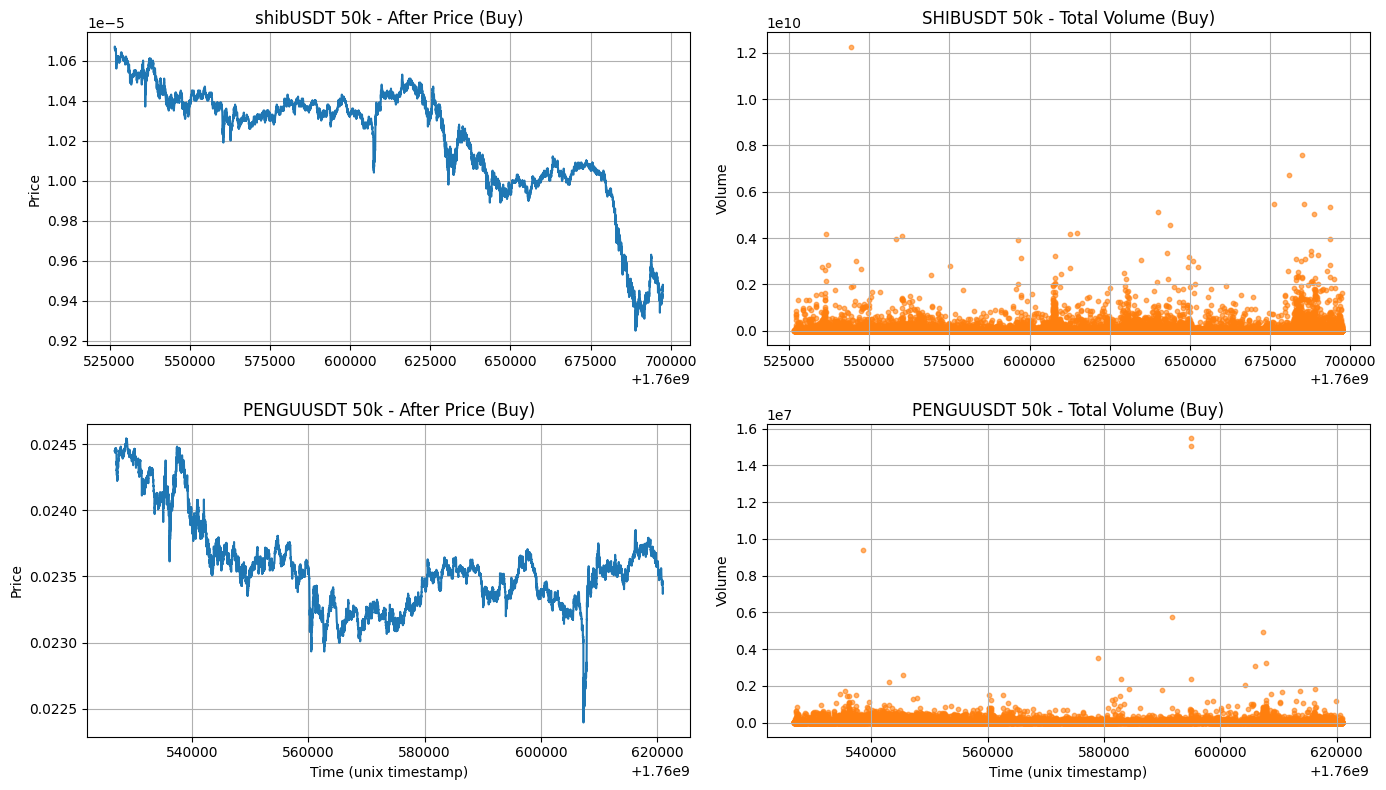

In [14]:
shib_50k_df = pd.read_csv('data/shib_50k.csv')
pengu_50k_df = pd.read_csv('data/pengu_50k.csv')

shib_50k_df = convert_emit_time_to_float(shib_50k_df)
pengu_50k_df = convert_emit_time_to_float(pengu_50k_df)
shib_50k_buy, shib_50k_sell = split_buy_sell(shib_50k_df)
pengu_50k_buy, pengu_50k_sell = split_buy_sell(pengu_50k_df)

shib_50k_buy_train, shib_50k_buy_test = temporal_train_test_split(shib_50k_buy)
shib_50k_sell_train, shib_50k_sell_test = temporal_train_test_split(shib_50k_sell)
pengu_50k_buy_train, pengu_50k_buy_test = temporal_train_test_split(pengu_50k_buy)
pengu_50k_sell_train, pengu_50k_sell_test = temporal_train_test_split(pengu_50k_sell)

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=False)

# SHIB 50k
axs[0, 0].plot(shib_50k_buy_train['emit_time_float'], shib_50k_buy_train['after_price'], color='tab:blue')
axs[0, 0].set_title('shibUSDT 50k - After Price (Buy)')
axs[0, 0].set_ylabel('Price')
axs[0, 0].grid(True)
axs[0, 1].scatter(shib_50k_buy_train['emit_time_float'], shib_50k_buy_train['total_volume'], s=10, color='tab:orange', alpha=0.6)
axs[0, 1].set_title('SHIBUSDT 50k - Total Volume (Buy)')
axs[0, 1].set_ylabel('Volume')
axs[0, 1].grid(True)

# PENGU 50k
axs[1, 0].plot(pengu_50k_buy_train['emit_time_float'], pengu_50k_buy_train['after_price'], color='tab:blue')
axs[1, 0].set_title('PENGUUSDT 50k - After Price (Buy)')
axs[1, 0].set_ylabel('Price')
axs[1, 0].grid(True)
axs[1, 1].scatter(pengu_50k_buy_train['emit_time_float'], pengu_50k_buy_train['total_volume'], s=10, color='tab:orange', alpha=0.6)
axs[1, 1].set_title('PENGUUSDT 50k - Total Volume (Buy)')
axs[1, 1].set_ylabel('Volume')
axs[1, 1].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel('Time (unix timestamp)')

plt.tight_layout()
plt.show()

SHIBUSDT
PENGUUSDT


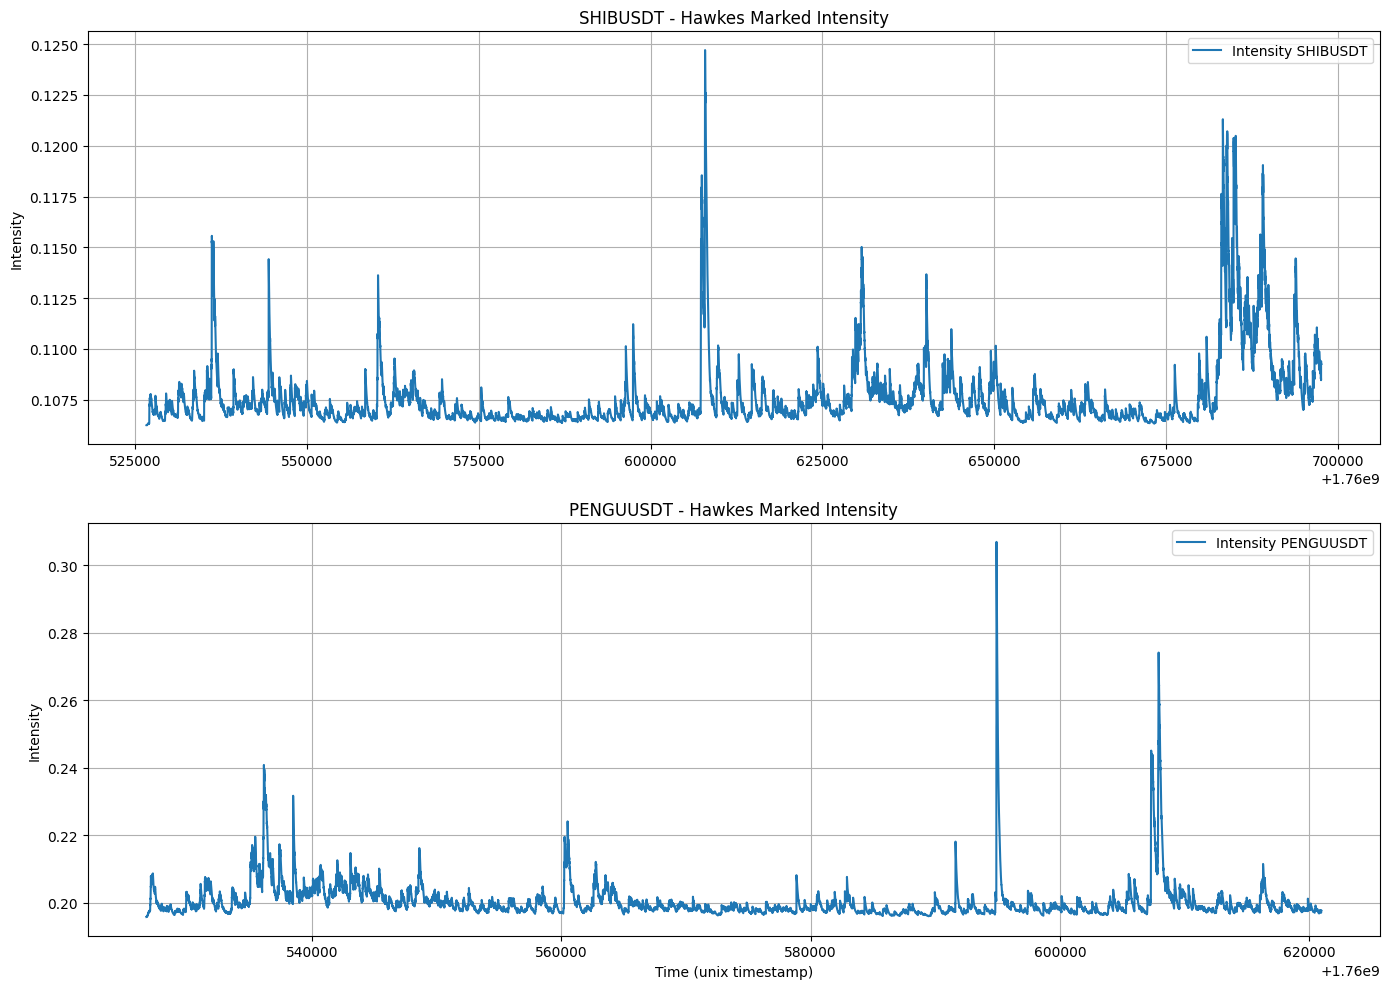

In [15]:
results = {}
cryptos = [
    ('SHIBUSDT', shib_50k_df, 0),
    ('PENGUUSDT', pengu_50k_df, 1)
]

for name, df, idx in cryptos:
    train_df = None
    if name == 'SHIBUSDT':
        train_df = shib_50k_buy_train
    elif name == 'PENGUUSDT':
        train_df = pengu_50k_buy_train
    print(name)
    event_times, intensities, params = reconstruct_intensity(train_df)
    results[name] = {
        'event_times': event_times,
        'intensities': intensities,
        'params': params
    }

# Example plot for each crypto
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)
for i, name in enumerate(results):
    axs[i].plot(results[name]['event_times'], results[name]['intensities'], label=f'Intensity {name}')
    axs[i].set_title(f'{name} - Hawkes Marked Intensity')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel('Time (unix timestamp)')
plt.tight_layout()
plt.show()

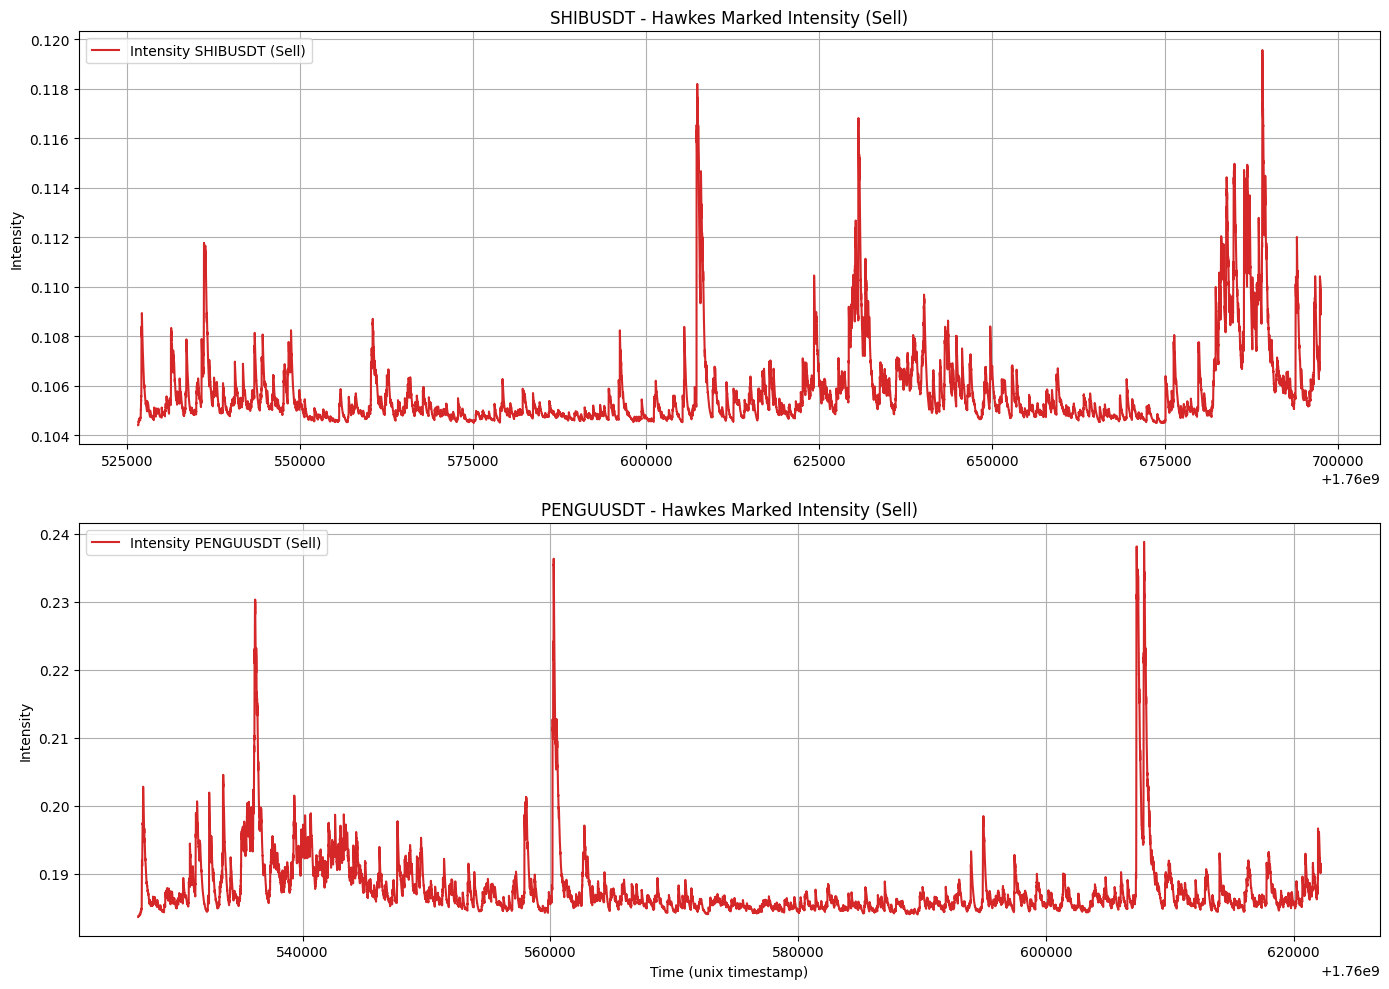

In [16]:
results_sell = {}
for name, df, idx in cryptos:
    train_df = None
    if name == 'SHIBUSDT':
        train_df = shib_50k_sell_train
    elif name == 'PENGUUSDT':
        train_df = pengu_50k_sell_train
    event_times, intensities, params = reconstruct_intensity(train_df)
    results_sell[name] = {
        'event_times': event_times,
        'intensities': intensities,
        'params': params
    }

# Example plot for each crypto (SELL side)
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)
for i, name in enumerate(results_sell):
    axs[i].plot(results_sell[name]['event_times'], results_sell[name]['intensities'], label=f'Intensity {name} (Sell)', color='tab:red')
    axs[i].set_title(f'{name} - Hawkes Marked Intensity (Sell)')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel('Time (unix timestamp)')
plt.tight_layout()
plt.show()

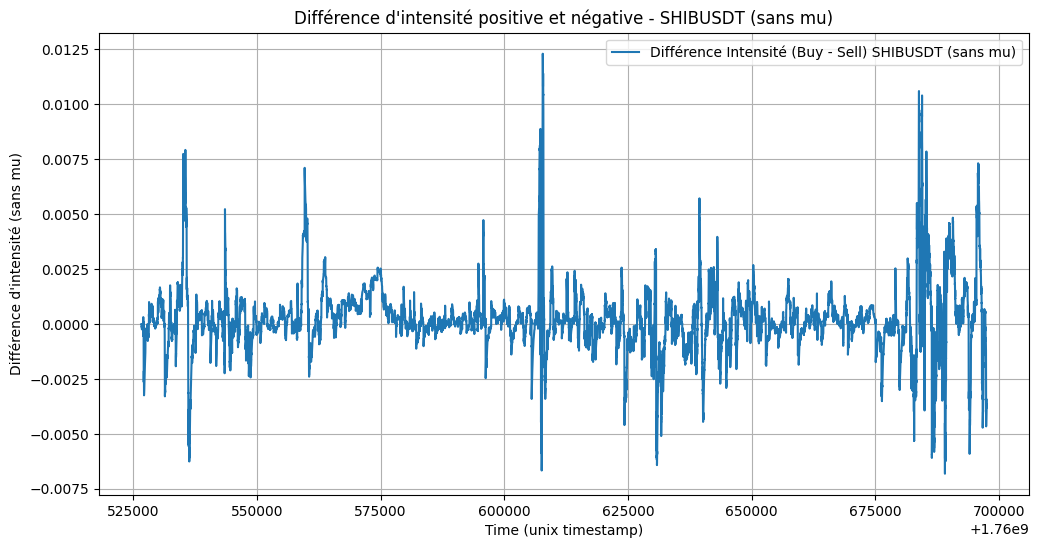

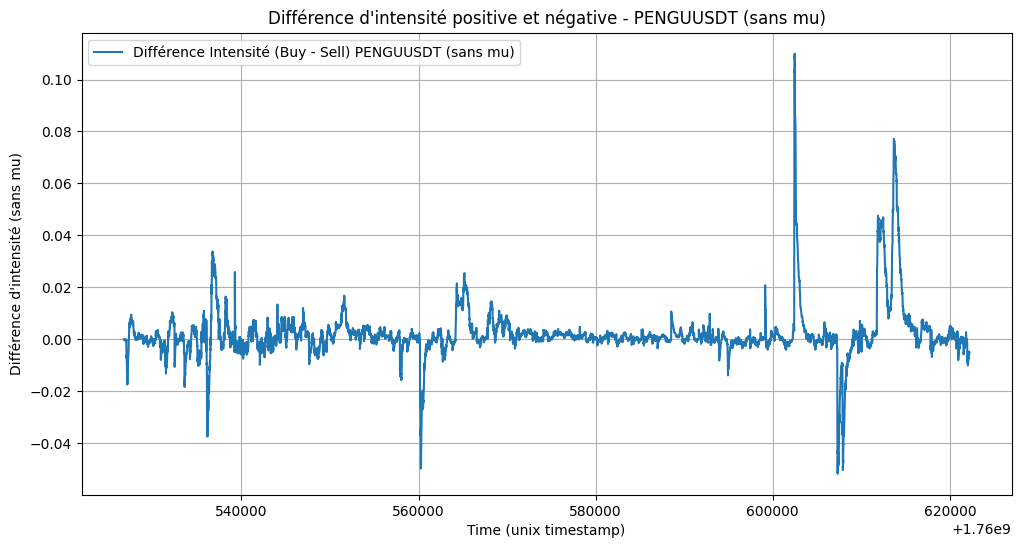

In [17]:
for name in results.keys():
    min_len = min(len(results[name]['intensities']), len(results_sell[name]['intensities']))
    # Remove mu from each intensity
    mu_buy = results[name]['params'][0]
    mu_sell = results_sell[name]['params'][0]
    intensity_diff = (results[name]['intensities'][:min_len] - mu_buy) - (results_sell[name]['intensities'][:min_len] - mu_sell)
    event_times = results_sell[name]['event_times'][:min_len]

    plt.figure(figsize=(12, 6))
    plt.plot(event_times, intensity_diff, label=f"Différence Intensité (Buy - Sell) {name} (sans mu)")
    plt.title(f"Différence d'intensité positive et négative - {name} (sans mu)")
    plt.xlabel("Time (unix timestamp)")
    plt.ylabel("Différence d'intensité (sans mu)")
    plt.grid(True)
    plt.legend()
    plt.show()

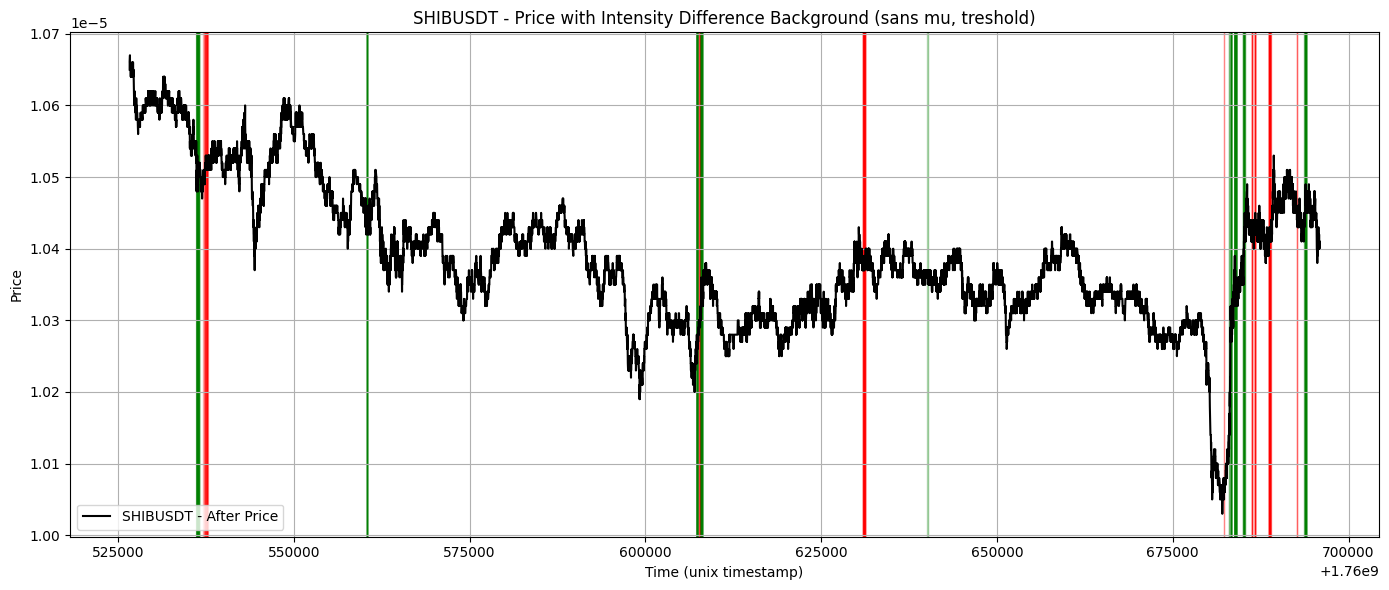

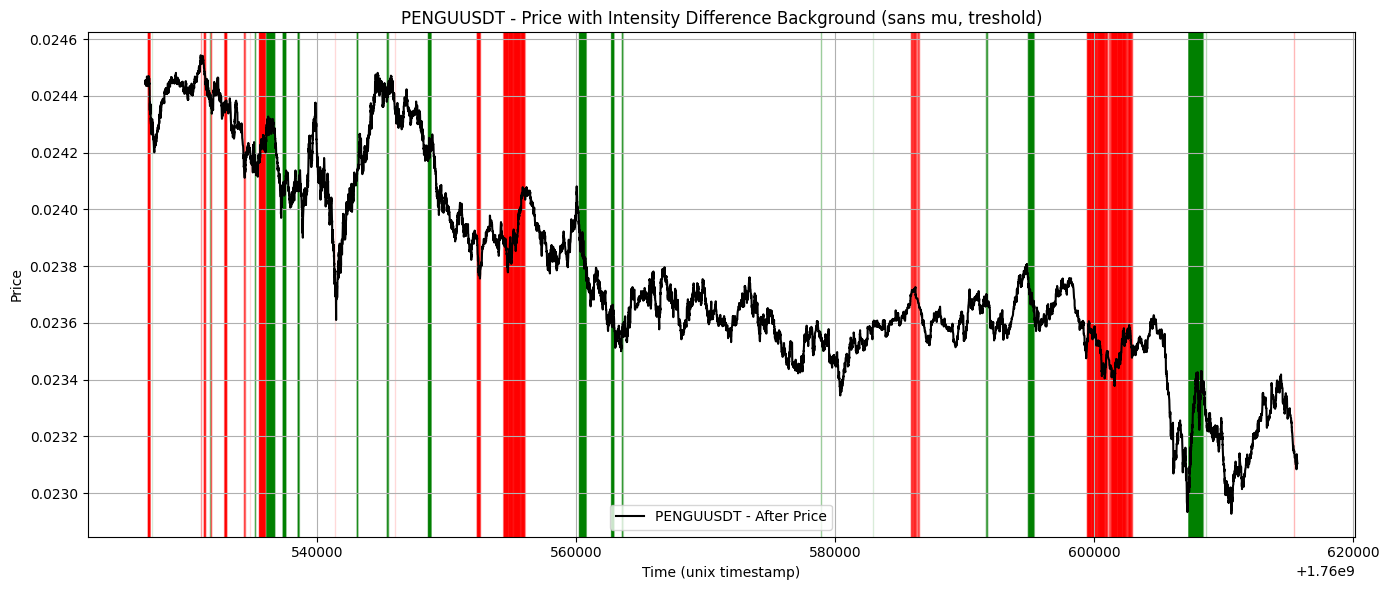

In [18]:
for name, df, idx in cryptos:
    min_len = min(len(results[name]['event_times']), len(results_sell[name]['event_times']))
    event_times = results[name]['event_times'][:min_len]
    price = df['after_price'].values[:min_len]
    # Remove mu from each intensity
    mu_buy = results[name]['params'][0]
    mu_sell = results_sell[name]['params'][0]
    intensity_buy = results[name]['intensities'][:min_len] - mu_buy
    intensity_sell = results_sell[name]['intensities'][:min_len] - mu_sell
    diff_norm = (intensity_buy - intensity_sell) / (np.abs(intensity_buy) + np.abs(intensity_sell) + 1e-9)

    threshold = 0.05 * np.mean([mu_buy, mu_sell])

    plt.figure(figsize=(14, 6))
    plt.plot(event_times, price, label=f'{name} - After Price', color='black', linewidth=1.5)
    for i in range(min_len - 1):
        if np.abs(intensity_buy[i] - intensity_sell[i]) > threshold:
            color = 'green' if diff_norm[i] > 0 else 'red'
            plt.axvspan(event_times[i], event_times[i+1], color=color, alpha=0.15)

    plt.title(f'{name} - Price with Intensity Difference Background (sans mu, treshold)')
    plt.xlabel('Time (unix timestamp)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


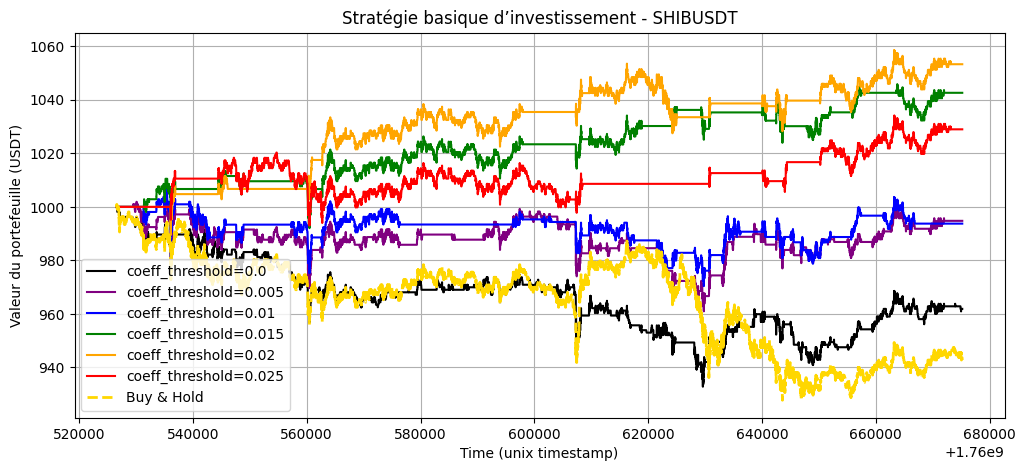

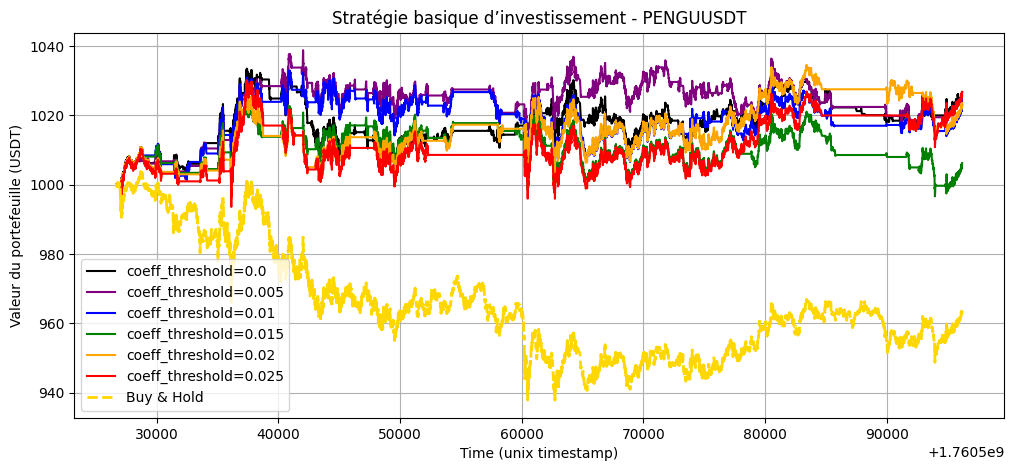

In [19]:
# --- Paramètres initiaux ---
initial_usdt = 1000.0

# --- Liste des coefficients de seuil à tester ---
coeffs = [0.005 * i for i in range(20)]
colors = ['black', 'purple', 'blue', 'green', 'orange', 'red']


# --- Graphiques séparés pour chaque paire ---
plot_thresholds_with_bh('SHIBUSDT', results, results_sell, shib_50k_buy_train)
plot_thresholds_with_bh('PENGUUSDT', results, results_sell, pengu_50k_buy_train)

## Bibliography

- **Lee, K., & Seo, B. K.** (2017).
  *Marked Hawkes process modeling of price dynamics and volatility estimation*.
  **Journal of Empirical Finance**, *40*, 174–220.
  [DOI:10.48550/arXiv.1907.12025](https://doi.org/10.48550/arXiv.1907.12025)
  [arXiv:1907.12025 [q-fin.ST]](https://arxiv.org/abs/1907.12025)